<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/2022-2/notebooks/6a_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento de máquinas de vectores de soporte mediante descenso por sub-gradiente
En esta libreta veremos cómo entrenar una máquina de vectores de soporte lineal usando el algoritmo PEGASOS (_Primal Estimated sub-GrAdient SOlver for SVM_)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import cvxopt
cvxopt.solvers.options['show_progress'] = False

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics.pairwise import rbf_kernel

## Frontera de decisión
Antes de cargar el conjunto de datos y programar nuestro SVM, vamos a definir una función para dibujar la frontera de decisión de un clasificador.

In [2]:
def dibuja_frontera(modelo, X_ent, y_ent, X_val, y_val, tm = 0.02):
  fig, ax = plt.subplots()
  ax.scatter(X_ent[:, 0], X_ent[:, 1], c=y_ent, cmap=plt.cm.coolwarm, 
             s=20, edgecolors='k')
  ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=plt.cm.coolwarm, 
             s=20, edgecolors='k')

  ax = plt.gca()
  xlim = ax.get_xlim()
  ylim = ax.get_ylim()
  xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                       np.linspace(ylim[0], ylim[1], 50))

  Z = modelo.project(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  ax.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
              linestyles=['--', '-', '--'])
  plt.show()

## Clasificación lineal
Primero vamos a programar dos SVMs para clasificación lineal, los cuales probaremos en el conjunto de clasificación de flores iris en base a su ancho y largo sepal.

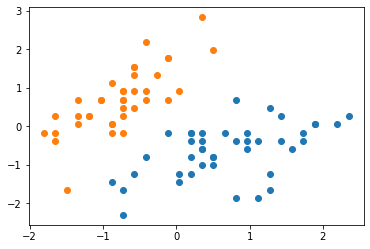

In [3]:
iris = datasets.load_iris()
    
subconj = np.where(iris['target'] < 2)
Xiris = iris['data'][subconj]
Xiris = Xiris[:, :2]
yiris = iris['target'][subconj]
yiris[yiris == 0] = -1

# dividimos el conjunto en entrenamiento y validación
Xiris_ent, Xiris_val, yiris_ent, yiris_val = train_test_split(Xiris, 
                                                              yiris, 
                                                              test_size=0.2, 
                                                              random_state=42)

# Entrenamos nuestro escalador y transformamos los atributos
sc = StandardScaler()
Xiris_ent = sc.fit_transform(Xiris_ent)
Xiris_val = sc.transform(Xiris_val)

plt.scatter(Xiris_ent[yiris_ent==1, 0], Xiris_ent[yiris_ent==1, 1], cmap=plt.cm.coolwarm)
plt.scatter(Xiris_ent[yiris_ent==-1, 0], Xiris_ent[yiris_ent==-1, 1], cmap=plt.cm.coolwarm)
plt.show()

### SVM lineal mediante [cvxopt](https://cvxopt.org/)
Usamos la función de optimización cuadrática `qp` de la biblioteca [cvxopt](https://cvxopt.org/) para resolver el problema dual dado por 

\begin{equation*}
      \begin{split}
        \text{maximiza } & \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y^{(i)} y^{(j)}\underbrace{\left[\left(\mathbf{x}^{(i)}\right)^\top \mathbf{x}^{(j)} \right]}_{k(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})}\\
        \text{sujeto a } & 0 \leq \alpha_i \leq C, \forall i, \sum_{i=1}^n \alpha_i y^{(i)} = 0
      \end{split}
    \end{equation*}

In [4]:
class SVMDualQP:
  def __init__(self, C = 1, eps = 1e-7):
    self.C = C
    self.eps = eps

  def prod(self, x):
    return [a * self.ys[i] * (self.xs[i].T @ x) for i,a in enumerate(self.alfas)]

  def fit(self, X, y):
    n = X.shape[0]
    d = X.shape[1]
  
    P = cvxopt.matrix(np.outer(y, y) * (X @ X.T), tc='d')
    q = cvxopt.matrix(-np.ones(n))
    A = cvxopt.matrix(y[np.newaxis, :], tc='d')
    f = cvxopt.matrix(0, tc='d')

    G = cvxopt.matrix(np.vstack((-np.eye(n), np.eye(n))))
    h = cvxopt.matrix(np.hstack((np.zeros(n), np.ones(n) * self.C)))

    minimization = cvxopt.solvers.qp(P, q, G, h, A, f)
    a = np.ravel(minimization['x'])
    indvs = a > self.eps
    self.alfas = a[indvs]
    self.xs = X[indvs]
    self.ys = y[indvs]

    self.b = self.ys[0] - np.sum(self.prod(self.xs[0]))

  def project(self, X):
    y = np.zeros(X.shape[0])
    for i,e in enumerate(X):
      y[i] = np.sum(self.prod(e)) + self.b

    return y

  def predict(self, X):
    return np.sign(self.project(X))

Instanciamos nuestra clase y entrenamos nuestro clasificador

In [5]:
svm = SVMDualQP(C=1)
svm.fit(Xiris_ent, yiris_ent)

Evaluamos el clasificador entrenado en el conjunto de validación:

In [6]:
pred_val = svm.predict(Xiris_val)
print(f'Exactitud = {accuracy_score(pred_val, yiris_val) * 100}%')

Exactitud = 100.0%


### PEGASOS lineal
De formar alternativa, es posible entrenar una máquina de vectores de soporte lineal usando el algoritmo PEGASOS (_Primal Estimated sub-GrAdient SOlver for SVM_), el cual usa el subgradiente dado por

$$
\tilde{\nabla}E(\mathbf{w}, b) = 
\begin{cases}
0, & y^{(i)} \cdot (\mathbf{w}^\top \mathbf{x}^{(i)} + b) \geq 1\\
y^{(i)} \cdot \mathbf{x}^{(i)}, & y^{(i)} \cdot (\mathbf{w}^\top \mathbf{x}^{(i)} + b) < 1
\end{cases}
$$

El procedimiento general del algoritmo PEGASOS es el que sigue:

* Inicializamos $\mathbf{w}$ y $b$ a $0$
* Para $t = 1,\ldots, T$ realizar
  * Elige ejemplo $\{x^{(i)}, y^{(i)}\}$ aleatoriamente
  * $\eta^{t} = \frac{1}{\lambda \cdot t}$
  * Si $y^{(i)} (\mathbf{w}_t^\top \mathbf{x}^{(i)} + b) < 1$, entonces
$$
  \mathbf{w}^{t+1} = (1 - \eta^t\cdot \lambda)\cdot \mathbf{w}^t + \eta^t\cdot y^{(i)} \cdot \mathbf{x}^{(i)}
$$

  * En caso contrario

$$
  \mathbf{w}^{t+1} = (1 - \eta^t\cdot \lambda)\cdot \mathbf{w}^t
$$

In [7]:
class PEGASOSLineal:
  def __init__(self, n_iter = 1000, l = 0.01):
    self.n_iter = n_iter
    self.l = l

  def fit(self, X, y):
    n = X.shape[0]
    d = X.shape[1]
    
    Xd = np.column_stack((np.ones(X.shape[0]), X))
    self.w = np.zeros((d + 1, 1))

    t = 0
    for i in range(self.n_iter):
      perm = np.random.permutation(n)
      for j in range(n):
        t += 1
        decay = 1.0 / t
        eta_t = decay  / self.l

        # Elegimos el siguiente par (xi,yi)
        Xsub = Xd[perm[j]][np.newaxis, :]
        ysub = y[perm[j]]

        pred = ysub * (Xsub @ self.w)
        self.w = (1 - decay) * self.w

        if pred < 1:
          self.w += eta_t * ysub * Xsub.T

  def project(self, X):
    Xd = np.column_stack((np.ones(X.shape[0]), X))
    return Xd @ self.w

  def predict(self, X):
    return np.sign(self.project(X))

Entrenamos nuestro modelo usando el algoritmo PEGASOS

In [8]:
pegasoslin = PEGASOSLineal(l = 0.001)
pegasoslin.fit(Xiris_ent, yiris_ent)

Predecimos las clases de los datos de validación y evaluamos su exactitud![texto alternativo](https://)

In [9]:
yiris_ent_predicha = pegasoslin.predict(Xiris_ent)
yiris_val_predicha = pegasoslin.predict(Xiris_val)

print(f'Exactitud Ent = {accuracy_score(yiris_ent, yiris_ent_predicha) * 100}%')    
print(f'Exactitud Val = {accuracy_score(yiris_val, yiris_val_predicha) * 100}%')    

Exactitud Ent = 100.0%
Exactitud Val = 100.0%


Imprimimos los pesos encontrados

In [10]:
print(f'w_1 = {pegasoslin.w[1][0]}, w_2 = {pegasoslin.w[2][0]}, b = {pegasoslin.w[0][0]}')

w_1 = 4.128376601538176, w_2 = -2.474878156093176, b = 1.0625000000000029


Visualizamos el híperplano y los vectores de soporte

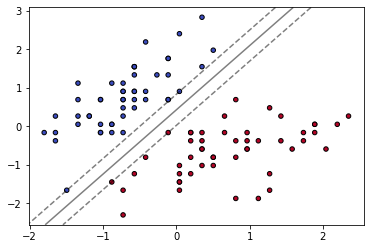

In [11]:
dibuja_frontera(pegasoslin, Xiris_ent, yiris_ent, Xiris_val, yiris_val)

## Clasificación no lineal
Ahora vamos a programar un SVM para clasificación no lineal, el cual probaremos en un conjunto de datos sintético,

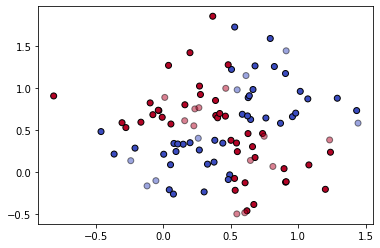

In [12]:
np.random.seed(42)
Xsin = 0.5 + 0.5 * np.random.randn(100, 2)
ysin = np.logical_xor(Xsin[:, 0] > 0.5, Xsin[:, 1] > 0.5).astype(int)
ysin[ysin == 0] = -1

Xsin_ent, Xsin_val, ysin_ent, ysin_val = train_test_split(Xsin, ysin, test_size=0.2, random_state=42)

plt.scatter(Xsin_ent[:, 0], Xsin_ent[:, 1], c=ysin_ent, cmap=plt.cm.coolwarm, edgecolors="k")
plt.scatter(Xsin_val[:, 0], Xsin_val[:, 1], c=ysin_val, cmap=plt.cm.coolwarm, alpha=0.5, edgecolors="k")
plt.show()

### PEGASOS _kernelizado_
El algoritmo PEGASOS se puede usar para entrenar un SVM definido a partir de los parámetros $\alpha_i, i=1, \ldots, n$. Esta versión de PEGASOS es la siguiente:

* Inicia $\alpha_i^{\{0\}}, i=1, \ldots, n$ a $0$
* Para $t = 1,\ldots, T$ realizar
  * Elige el índice de un ejemplo aleatoriamente $s \in \{1, \ldots, n\}$
  * $\eta^{t} = \frac{1}{\lambda \cdot t}$
  * Si $y^{(s)} \cdot \left[\frac{1}{\lambda \cdot t} \cdot \sum_{i=1}^n \alpha_i \cdot y^{(i)}\cdot K(\mathbf{x}^{i}, \mathbf{x}^{s})\right] < 1$, entonces
  $$
  \alpha_s^{\{t\}} = \alpha_s^{\{t-1\}} + 1
  $$
  * En caso contrario

$$
  \alpha_s^{\{t\}} = \alpha_s^{\{t-1\}}
$$

Esto permite usar _kernels_ en nuestro clasificador. Como función _kernel_ usaremos la función de base radial, definida como
$$
    k(\mathbf{x}^{(i)},\mathbf{x}^{(j)}) = \exp{ \left(-\frac{\lVert \mathbf{x}^{(i)} - \mathbf{x}^{(j)}\rVert_2^2}{2\sigma^2} \right) }
$$   

In [13]:
class PEGASOSRBF:
  def __init__(self, n_iter = 1000, l = 0.001, eps=1e-5):
    self.n_iter = n_iter
    self.l = l
    self.eps = eps 
    self.kernel = rbf_kernel

  def fit(self, X, y):
    n = X.shape[0]
    d = X.shape[1]
    K = rbf_kernel(X)
    alfas = np.zeros(n)
    
    t = 1
    for i in range(self.n_iter):
      perm = np.random.permutation(n)
      for j in range(n):
        eta_t = 1.0 / (self.l * t)

        Xsub = X[perm[j]][np.newaxis, :]
        ysub = y[perm[j]]

        if ysub * eta_t  * np.sum(alfas * y * K[:,perm[j]]) < 1:
          alfas[perm[j]] += 1

        t += 1

    indvs = alfas > self.eps
    self.alfas = alfas[indvs]
    self.xs = X[indvs]
    self.ys = y[indvs]

  def project(self, X):
    K = self.kernel(self.xs, X)
    y = np.zeros(X.shape[0])
    for i,e in enumerate(X):
      proj = self.alfas * self.ys * K[:,i]      
      y[i] = np.sum(proj)

    return y

  def predict(self, X):
    return np.sign(self.project(X))

Entrenamos nuestro clasificador.

In [14]:
pegasosrbf = PEGASOSRBF(l = 0.01)
pegasosrbf.fit(Xsin_ent, ysin_ent)

In [15]:
ysin_ent_predicha = pegasosrbf.predict(Xsin_ent)
ysin_val_predicha = pegasosrbf.predict(Xsin_val)

print(f'Exactitud Ent = {accuracy_score(ysin_ent, ysin_ent_predicha) * 100}%')    
print(f'Exactitud Val = {accuracy_score(ysin_val, ysin_val_predicha) * 100}%')       

Exactitud Ent = 92.5%
Exactitud Val = 100.0%


Dibujamos la frontera de decisión:

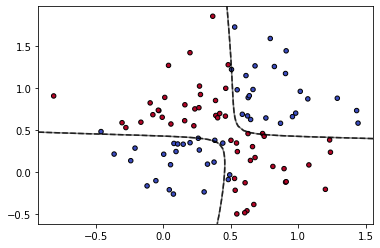

In [16]:
dibuja_frontera(pegasosrbf, Xsin_ent, ysin_ent,  Xsin_val, ysin_val)

## Ejercicio
+ Modifica la clase `SVMDualQP` para incluir un kernel.
+ Prueba el algoritmo PEGASOS con diferentes valores de $\lambda$.
+ Modifica la clase `PEGASOSLineal` para actualizar los parámetros por minilote.